This notebooks explores how to create a cloropleth to count the number of stations in a defined grid.

---
Author: Jordi Grau Escolano


# 1. Load data

In [11]:
import sys, ast
import numpy as np
from pathlib import Path
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
import matplotlib as mpl  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore
from shapely.geometry import Polygon
import osmnx as ox

# Add project root to path
project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho
import src.optimization.experiments.graph_metrics.different_cities.GA_execution as gae

ROOT = ".."

# Load bcn boundary
bcn_boundary = dl.load_bcn_boundary()

# Parse weights
def parse_weights(weights_str):
    weights = ast.literal_eval(weights_str)
    return {k.strip(): float(v) for k, v in [item.split(':') for item in weights]}

# Load data
df, G, distance_matrix, id_to_idx, idx_to_id, _, STATION_MIN_DISTANCE = he.load_data(root=ROOT)
weights = {'population': 1}
df_weighted = ho.sum_and_normalize_all_node_scores(df, weights)
N_STATIONS = 100

# Generate one initial solution
solution = ho.generate_one_initial_solution(N_STATIONS, distance_matrix, STATION_MIN_DISTANCE, idx_to_id, id_to_idx)
df_solution = df_weighted[df_weighted.index.isin(solution)]

# Validate the solution
ho.validate_solution(solution, distance_matrix, id_to_idx, idx_to_id, N_STATIONS, STATION_MIN_DISTANCE)

	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ../data/processed/nodes/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)


True

# 2. Barcelona plot

In [17]:
def plot_nodes(df_weighted, ax, boundary, show_colorbar=True, show_normalization_raw_score=False):
    """
    Plot all nodes on a map
    """
    boundary.boundary.plot(ax=ax, color='black', alpha=0.7)

    # Plot stations
    scatter = df_weighted.plot(
        column='norm_score',
        cmap=plt.cm.viridis_r,
        ax=ax,
        markersize=0.5,
        legend=False,
        vmin=0, vmax=1)

    # Add colorbar
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        
        # Create colorbar with continuous scale
        cb = mpl.colorbar.ColorbarBase(
            cax,
            cmap=plt.cm.viridis_r,
            norm=mpl.colors.Normalize(vmin=0, vmax=1),
            spacing='proportional'
        )
        
        cb.ax.tick_params(labelsize=8)
        if show_normalization_raw_score:
            original_min, original_max = df_weighted["norm_score"].min(), df_weighted["norm_score"].max()
            cb.set_label(f'Score (min={original_min:.2f}, max={original_max:.2f})', fontsize=8)
        else:
            cb.set_label('Normalized Score', fontsize=8)

    # Add basemap
    ctx.add_basemap(
        ax, source=ctx.providers.CartoDB.Positron, crs=df_weighted.crs.to_string(), zoom=12)

    ax.set_axis_off()

In [13]:
def create_grid_cells_and_count_points(boundary, df_solution, grid_size=500, crs=25830):
    
    # Create grid cells
    xmin, ymin, xmax, ymax = boundary.total_bounds
    xmin, ymin, xmax, ymax = xmin - 1000, ymin - 1000, xmax + 1000, ymax + 1000
    x_coords = np.arange(xmin, xmax, grid_size)
    y_coords = np.arange(ymin, ymax, grid_size)
    polygons = []
    for x in x_coords[:-1]:
        for y in y_coords[:-1]:
            polygons.append(Polygon([
                (x, y),
                (x + grid_size, y),
                (x + grid_size, y + grid_size),
                (x, y + grid_size)
            ]))
    grid_cells = gpd.GeoDataFrame(geometry=polygons, crs=boundary.crs)
    
    # Only keep cells that intersect with boundary
    grid_cells = grid_cells[grid_cells.intersects(boundary.unary_union)]

    # Count the number of points in each grid cell
    grid_cells = gpd.GeoDataFrame(grid_cells.sjoin(df_solution).groupby('geometry').size().reset_index(name='n_points'), crs=crs)
    return grid_cells



def plot_grid_cells(boundary, df_solution, grid_size, ax, crs=25830, show_colorbar=True):

    df_solution = df_solution.to_crs(crs)
    boundary = boundary.to_crs(crs)
    
    # Count the number of stations in each grid cell
    grid_cells = create_grid_cells_and_count_points(boundary, df_solution, grid_size)

    # Plot the grid cells
    boundary.boundary.plot(ax=ax, color='black', alpha=0.7)
    
    # Get unique values and create bounds
    unique_values = sorted(grid_cells['n_points'].unique())
    n_classes = len(unique_values)
    bounds = np.linspace(min(unique_values), max(unique_values), n_classes + 1)
    
    # Create custom colormap
    cmap = plt.cm.viridis_r  # base colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_classes)
    
    # Define the normalization
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot grid cells with station counts
    plot = grid_cells.plot(
        column='n_points',
        cmap=cmap,
        norm=norm,
        ax=ax,
        alpha=0.75,
        legend=False,
        linewidth=0.5
    )

    # Add colorbar
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        
        # Create colorbar with integer ticks
        cb = mpl.colorbar.ColorbarBase(
            cax, 
            cmap=cmap,
            norm=norm,
            spacing='proportional',
            ticks=bounds,
            boundaries=bounds,
            format='%1i'
        )
        
        cb.ax.tick_params(labelsize=8)
        cb.set_label('Number of stations', fontsize=8)

    # Add basemap
    ctx.add_basemap(
        ax, source=ctx.providers.CartoDB.Positron, crs=df_solution.crs.to_string(), zoom=12)

    ax.set_axis_off()
    return grid_cells

/tmp/ipykernel_19075/110719624.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_cells = grid_cells[grid_cells.intersects(boundary.unary_union)]


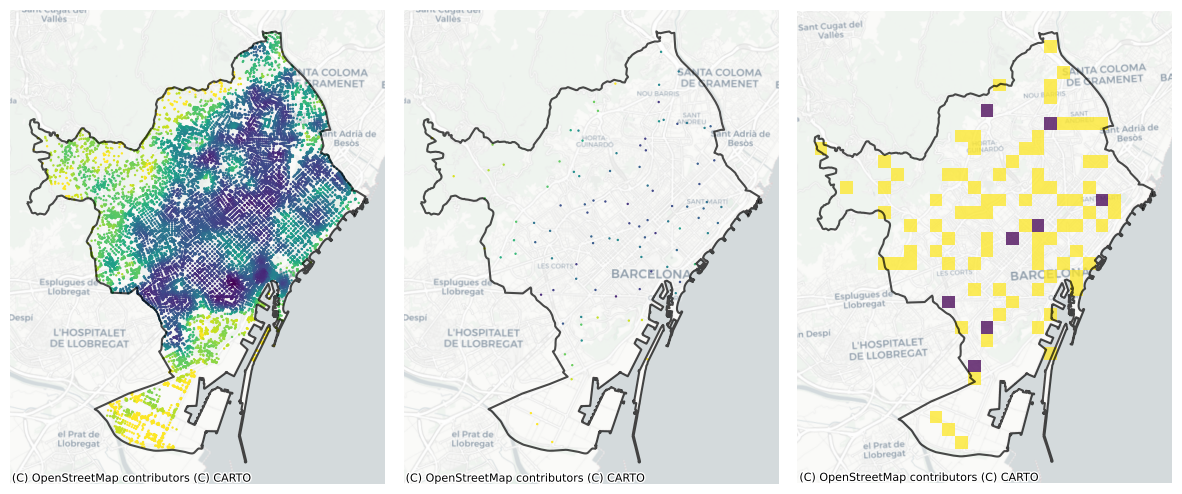

In [14]:
# Without colorbar
fig, axs = plt.subplots(1,3, figsize=(15, 10), gridspec_kw={'wspace': 0.05})

# All nodes
plot_nodes(df_weighted, axs[0], bcn_boundary, show_colorbar=False, show_normalization_raw_score=True)

# Only stations
plot_nodes(df_solution, axs[1], bcn_boundary, show_colorbar=False, show_normalization_raw_score=False)

# Grid cells
plot_grid_cells(bcn_boundary, df_solution, grid_size=500, ax=axs[2], show_colorbar=False)

plt.show()

/tmp/ipykernel_19075/110719624.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_cells = grid_cells[grid_cells.intersects(boundary.unary_union)]


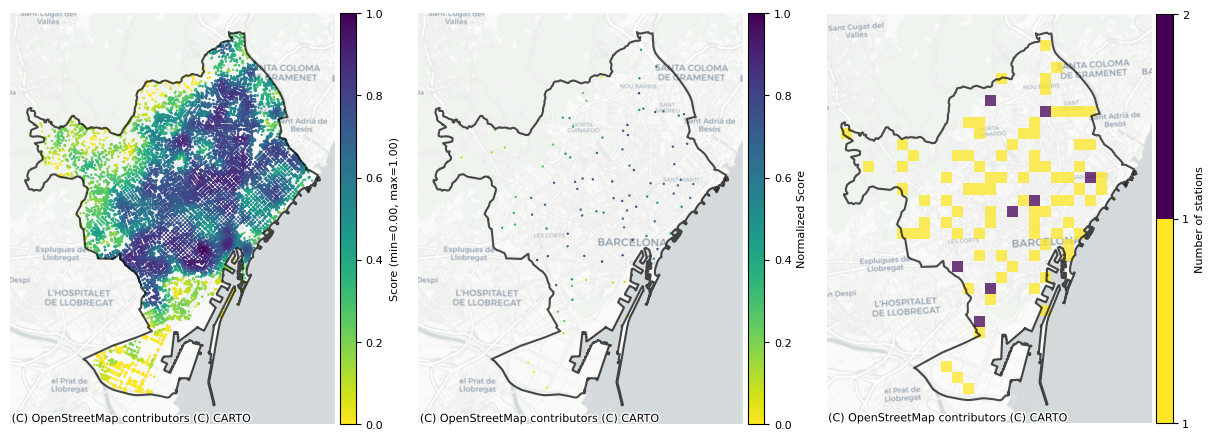

In [15]:
# With colorbar
fig, axs = plt.subplots(1,3, figsize=(15, 10), gridspec_kw={'wspace': 0.18})

plot_nodes(df_weighted, axs[0], bcn_boundary, show_colorbar=True, show_normalization_raw_score=True) # All nodes
plot_nodes(df_solution, axs[1], bcn_boundary, show_colorbar=True, show_normalization_raw_score=False) # Only stations
plot_grid_cells(bcn_boundary, df_solution, grid_size=500, ax=axs[2], show_colorbar=True) # Grid cells

plt.show()

# 3. València plot

In [18]:
# Load one BSS solution 
file_ga = pd.read_csv(f'{ROOT}/{PR_EXP}/GA_alpha_screening/different_cities/alpha_comparison_multiply.csv')
df_ga = pd.DataFrame(file_ga)[['experiment_idx', 'city', 'N_stations', 'alpha', 'best_score', 'minutes_to_complete', 'best_solution']]

# Dropna in best_solution
df_ga = df_ga.dropna(subset=['best_solution'])
df_ga['best_solution'] = df_ga['best_solution'].astype(str).str.strip('[]').str.split(',').apply(lambda x: [int(node.strip()) for node in x if node.strip()])
experiment = df_ga.iloc[1]
solution = experiment['best_solution']

# download Valencia OSM boundary
boundary = ox.geocode_to_gdf(f"{experiment['city']}, Spain")

In [ ]:
# Load data
weights = {'population': 1}
df, G, distance_matrix, id_to_idx, idx_to_id, STATION_MIN_DISTANCE = gae.compute_shared_data(experiment['city'], epsg=25830, root=ROOT)
df_weighted = ho.sum_and_normalize_all_node_scores(df, weights)

In [ ]:
# Get the nodes' geometry from the graph
nodes_gdf, _ = ox.graph_to_gdfs(G)
nodes_gdf = nodes_gdf.to_crs(4326)
nodes_gdf = nodes_gdf[['geometry']]
nodes_gdf.index.name = 'node_id'
nodes_gdf.index = nodes_gdf.index.astype(int)

# merge on index
df_weighted = df_weighted.merge(nodes_gdf, left_index=True, right_index=True)
df_weighted = gpd.GeoDataFrame(df_weighted).to_crs(4326)

# Generate one initial solution
N_STATIONS = len(solution)
# solution = ho.generate_one_initial_solution(N_STATIONS, distance_matrix, STATION_MIN_DISTANCE, idx_to_id)
df_solution = df_weighted[df_weighted.index.isin(solution)]

# Validate the solution
ho.validate_solution(solution, distance_matrix, id_to_idx, N_STATIONS, STATION_MIN_DISTANCE)

/tmp/ipykernel_2738/110719624.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_cells = grid_cells[grid_cells.intersects(boundary.unary_union)]


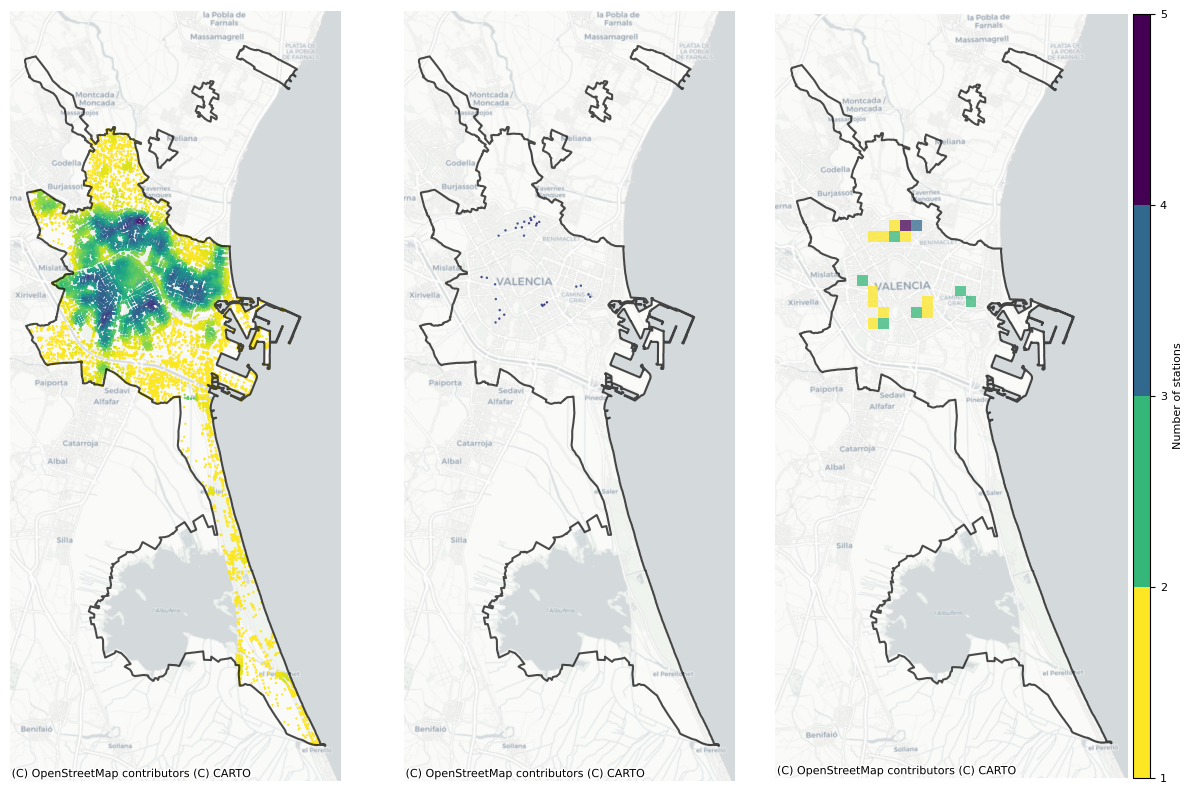

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 10), gridspec_kw={'wspace': 0.05})

plot_nodes(df_weighted, axs[0], boundary, show_colorbar=False, show_normalization_raw_score=False)
plot_nodes(df_solution, axs[1], boundary, show_colorbar=False, show_normalization_raw_score=False)
plot_grid_cells(boundary, df_solution, grid_size=500, ax=axs[2], show_colorbar=True)

plt.show()